# Getting Started

Welcome to ReservoirPy !


ReservoirPy is a Python tool designed to easily define, train and use Reservoir Computing (RC) architectures, such as Echo State Networks (ESNs).

In the following tutorial, you will learn more about how to create an ESN with a few line of code, train it on some sequential data or timeseries and perform predictions. You will also learn more about ReservoirPy API, explained in more details in [this part of the documentation](https://reservoirpy.readthedocs.io/en/latest/user_guide/node.html).

Once you have completed this tutorial, you can check the others and learn more about online learning rules, custom weight matrices, hyperparameters and how to choose them, and how to build complex architectures.

In [1]:
import reservoirpy as rpy

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everyhting reproducible !

## A note on data formats

In ReservoirPy, **all data are stored in Numpy arrays**. It includes parameters of ReservoirPy Nodes and their input data. ReservoirPy uses only Numpy and Scipy for all computations.

All timeseries, from input data to reservoir's activations, are formated the same way: they must be Numpy arrays of shape $(timesteps, features)$. For instance, a timeseries composed of two variables samples over 100 timesteps would be stored in an array of shape $(100, 2)$. Single timesteps must also comply to this convention. A single timestep of the same 2-dimensional timeseries would be an array of shape $(1, 2)$. **Make sure to always comply with this formating** otherwise you migh obtain unexpected results, or raise an error.

When training or running over several independant timeseries, for instance using several audio signals or several sine wave at different frequency, an accepted shape may be $(series, timesteps, features)$. In that case, input data may be an array where all series have the same length $timesteps$, or a list of arrays storing timeseries of different lengths.

## Create your first Echo State Network

Echo State Networks (ESNs) are one of the simplest recurrent neural network architecture RC has to offer. They are built using two components: a **reservoir** and a **readout**.

The **reservoir** is a pool of artificial rate neurons randomly connected to their inputs and to themselves. Therefore, they are a genuine recurrent neural network similar to those which can be found in the field of machine learning in general. However, **none of the connections inside the reservoir are trained**. They are randomly initialized following several hyperparameters.

The random high dimensional activation vector of the reservoir is then fed to the **readout**, a single layer of neurons in charge with decoding the reservoir activations in order to perform a task. The connections between the readout and the reservoir are the only **learned** connections in an ESN. In consequence, there is no need for complicated learning algorithm such as backpropagation of error to train them: a simple linear regression such as a regularized ridge regression can make it.

Activations of the readout might also be fed back to the reservoir. This is called a **feedback** connection. This is an optional feature that can help tame the reservoir neurons activities.

The figure below summarizes what an ESN looks like. Connections between neurons are stored as Numpy arrays or Scipy sparse matrices. These connection weights are here represented as colored arrows. $W_{in}$ and $W$ are the inputs-to-reservoir and recurrent connections. $W_{out}$ represents the trained output weights of the readout. $W_{fb}$ represents the additional connections feeding the readout outputs back to the reservoir. 

![An ESN.](./static/esn.svg)

In ReservoirPy, an ESN is the association of two components: a reservoir Node and a readout Node, connected together. In this example, the reservoir will be created using the `Reservoir` class, and the readout using a `Ridge` node, able to perform regularized linear regression on the reservoir's activations $x$.

![An ESN in ReservoirPy](./static/esn_nodes.svg)

## Create a Reservoir

We will first create a reservoir for our ESN, with 100 neurons. Reservoirs can be created using the `Reservoir` class.

We change the value of two hyperparameters:
- `lr`: the *leaking rate*, which controls the time constant of the neurons;
- `sr`: the *spectral radius* of the recurrent connections in the reservoir. It controls the chaoticity of the reservoir dynamics.

You can find all parameters and hyperparameters in [the `Reservoir` class documentation](https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.nodes.Reservoir.html).

In [2]:
from reservoirpy.nodes import Reservoir

reservoir = Reservoir(100, lr=0.5, sr=0.9)

## Initialize and run the reservoir

This reservoir is empty for the moment: its parameters are not initialized yet. To start using the reservoir right now, you can run it on a timeseries, or use its `initialize()` method. Note that this method requires you to provide some samples of data, to infer the dimensions of some of the reservoir parameters, or to specify the input dimension of the reservoir at creation using the `input_dim` parameter. 

For now, let's run the reservoir on some data to visualize its activation.

We will start by using an univariate timeseries as input to the reservoir, 100 discrete timesteps sampled from a sine wave for instance. This sine wave is stored in a Numpy array of shape $(100, 1)$.

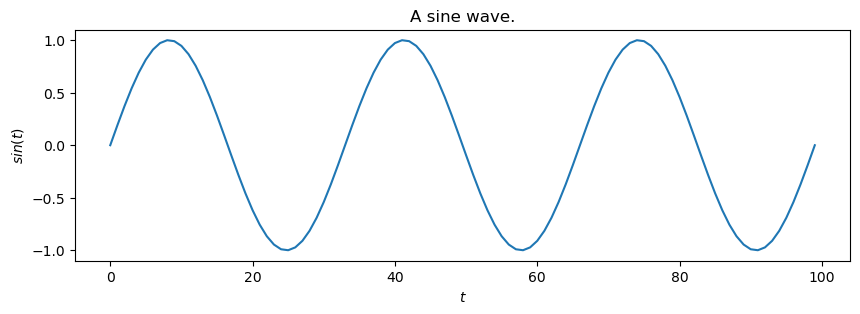

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1, 1)

plt.figure(figsize=(10, 3))
plt.title("A sine wave.")
plt.ylabel("$sin(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()

### Call on a single timestep

All ReservoirPy nodes such as `Reservoir`, can run over single timesteps of data or complete timeseries.

To run a node on a single timestep of data, use the call method:

In [4]:
s = reservoir(X[0].reshape(1, -1))

print("New state vector shape: ", s.shape)

New state vector shape:  (1, 100)


This has triggered the reservoir neurons on a single timestep of timeseries $X$.

Triggering a node on data not only returns the activations of that node, it also store this activation into the node internal state. This state can be accessed anytime using the `state()` method:

In [5]:
s = reservoir.state()

This internal state is initialized to a null vector by default, and **will be updated everytime you call the node on some data.** We can for instance perform successive calls to the reservoir to gather its activations of the whole timeseries: 

In [6]:
states = np.empty((len(X), reservoir.output_dim))
for i in range(len(X)):
    states[i] = reservoir(X[i].reshape(1, -1))

In the figure below, **we have plotted the activation of 20 neurons in the reservoir for every point of the timeseries**. Because the reservoir is a recurrent neural network, this state evolves in time following the evolution of the input timeseries.

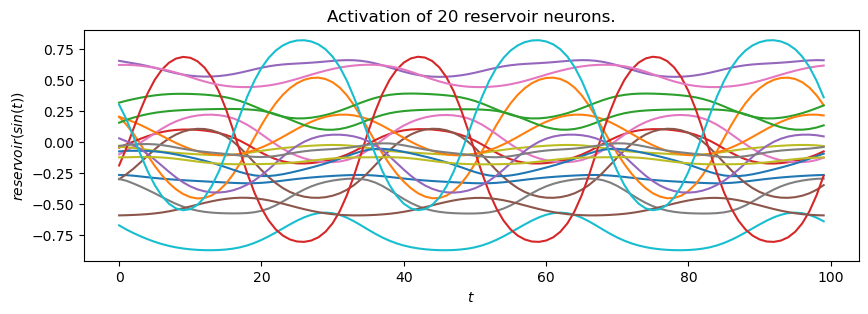

In [23]:
plt.figure(figsize=(10, 3))
plt.title("Activation of 20 reservoir neurons.")
plt.ylabel("$reservoir(sin(t))$")
plt.xlabel("$t$")
plt.plot(states[:, :20])
plt.show()

### Run over a whole timeseries

Gathering the activations of a node over a timeseries can be done without using a for-loop with the `run()` method.
This method takes arrays of shape $(timesteps, features)$ as input and returns an array of shape $(timesteps, states)$.

In [8]:
states = reservoir.run(X)

In [9]:
from reservoirpy.nodes import Reservoir, Ridge, FORCE, ESN

## Reset or modify reservoir state

A node state can then be reset to a null vector to wash out its internal memory using the `reset()` method.

In [10]:
reservoir = reservoir.reset()

It is also possible to reset the state of a node when using the call or the `run()` method, setting the `reset` parameter to `True`:

In [11]:
states_from_null = reservoir.run(X, reset=True)

States can also be fed to a node anytime using the `from_state` parameter of these methods. This allow for instance to reset a reservoir to a previous "memory state", or to a random one like in the code below:

In [12]:
a_state_vector = np.random.uniform(-1, 1, size=(1, reservoir.output_dim))

states_from_a_starting_state = reservoir.run(X, from_state=a_state_vector)

This operations can also be performed without erasing the node memory using the `with_state` context manager:

In [13]:
previous_states = reservoir.run(X)

with reservoir.with_state(reset=True):
    states_from_null = reservoir.run(X)
    
# as if the with_state never happened !
states_from_previous = reservoir.run(X) 

Everything happening inside the context manager will be erased when exiting it. The last state computed in `previous_states` is thus still availble when computing `states_from_previous`, although the internal states was temporarily reset to 0 to compute `states_from_null`.

These features allow to easily keep track of internal activations of nodes like reservoir, to modify them or to store them for later.

## Create a readout

Readouts works the same way as reservoirs. Internally, they are the same type of object, a *node*, and thus expose the same interface as described above: they have a call and a `run()` method, a `state()` (even if they are not necessarily a recurrent network), and so on.

However, *offline readouts* such as readouts trained with linear regression are not really initialized at first call, like the reservoir. They need to be **fitted**: the connections going from the reservoir to the readout neurons need to be learned from data.

Our first readout will be a simple [`Ridge` readout](https://reservoirpy.readthedocs.io/en/latest/api/generated/reservoirpy.nodes.Ridge.html#reservoirpy.nodes.Ridge), which can solve a task using linear regression.

With set the `ridge` parameter of the readout to $10^{-7}$. This is the *regularization*, an hyperparameter that will help avoid overfitting.

Note that we do not necessarily need to specify the number of output neurons in advance in a readout. It can be inferred at training time, and will be set to match the dimension of the teacher vectors.

In [14]:
from reservoirpy.nodes import Ridge

readout = Ridge(ridge=1e-7)

## Define a training task

Nodes like `Ridge` can be trained using their `fit()` method. This method takes as input two timeseries: a input timeseries and a target timeseries. During training, the readout will have to create a mapping from inputs to targets to solve a specific task: for instance, map a timestep $t$ of a timeseries to its timestep $t+1$. This would solve a one-timestep-ahead prediction task: from data at time $t$, predict data at time $t+1$.

For the sake of example, let's solve this one-timestep-ahead prediction task. Given the sine wave defined above, can we predict its behavior in advance ?

To learn this task, we create a copy of the timeseries $X$ shifted by one timestep, to obtain a target timeseries.

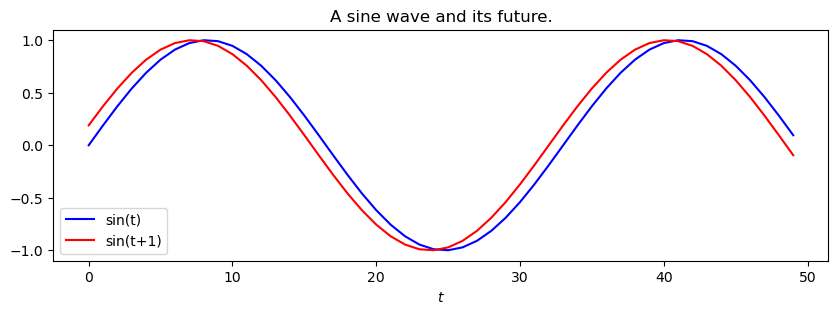

In [15]:
X_train = X[:50]
Y_train = X[1:51]

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(X_train, label="sin(t)", color="blue")
plt.plot(Y_train, label="sin(t+1)", color="red")
plt.legend()
plt.show()

Given any point in the blue wave, we seek to predict the corresponding point in the red wave.

## Train the readout

While this is not the recommended way of using a readout node, let's train it as a standalone node.
Our `Ridge` readout can be trained on `train_states` and `Y_train`, where `train_states` are the activations of the reservoir triggered by `X_train`.

First, we compute `train_states` using the `run()` method.

In [16]:
train_states = reservoir.run(X_train, reset=True)

Then, we train the readout using `fit()`. We use the `warmup` parameter to set the amount of timesteps we want to discard at the begining of `train_states`, when training. Indeed, as the internal state of the reservoir is recurrently updated bu start to a null value, it takes time before this state is representative of the input data.

In [17]:
readout = readout.fit(train_states, Y_train, warmup=10)

In the plot below, we can see training was sucessful: our readout is trying to predict the sine next value!

These results are not really impressive: a sine wave is easy to predict, and our readout still makes some mistakes. However, remember that we used only 50 timesteps of data to train that readout (40 actually, when discounting the 10 warmup steps). Reservoir and readouts together can obviously solve more complicated tasks, such as speech recognition or chaotic timeseries forecasting.

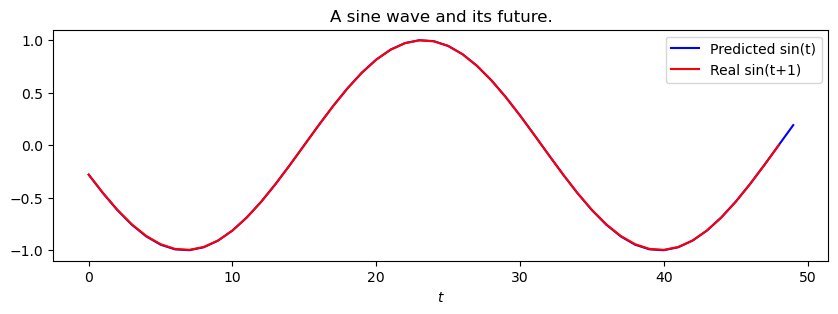

In [18]:
test_states = reservoir.run(X[50:])
Y_pred = readout.run(test_states)

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted sin(t)", color="blue")
plt.plot(X[51:], label="Real sin(t+1)", color="red")
plt.legend()
plt.show()

## Create the ESN model

Now that we have created a readout and a reservoir, and that we have seen how to run and train them, let's connect them to create an ESN. This section describes the "cannonical" method for creating and training ESNs.

In ReservoirPy, connecting nodes together leads to the creation of `Model` objects. Models are a specific type of node containing other nodes, and a description of all the connections between them. When run, a Model will run all the nodes it contains, and make the data follow their declared connections. When trained, it will also take care of training all its readouts.

An ESN is a very simple type of Model, containing two nodes: a reservoir and a readout. When run, an ESN Model will first run the reservoir, feed the reservoir activations to the readout and run the readout on them.

To declare connections between nodes and build a model, use the `>>` operator:

In [19]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

## Train the ESN

Once the Model is created, it can be trained using its `fit()` method:

In [20]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)

You can check that this method has initialized all nodes in the Model, and trained the `Ridge` readout.

In [21]:
print(reservoir.is_initialized, readout.is_initialized, readout.fitted)

True True True


## Run the ESN

We can then run the model on unseen next values on the timeseries to evaluate it, as shown below.

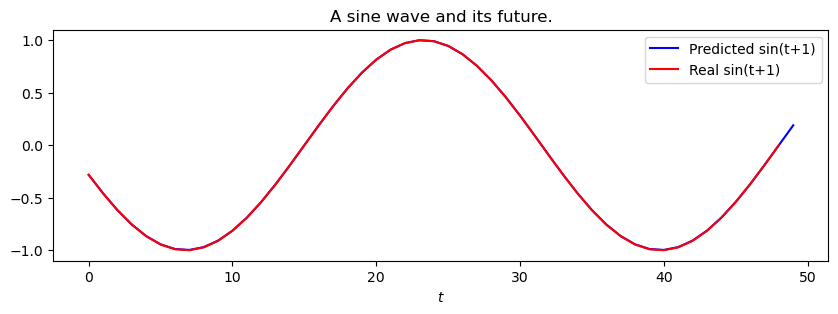

In [22]:
Y_pred = esn_model.run(X[50:])

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted sin(t+1)", color="blue")
plt.plot(X[51:], label="Real sin(t+1)", color="red")
plt.legend()
plt.show()